In [1]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'none'

# seaborn package for making pretty plots, but not necessary
try:
    import seaborn as sns
    params =   {'xtick.direction': 'in', 'ytick.direction': 'in', 'font.family': ['serif'],
                'text.usetex': True, 'text.latex.preamble': ['\usepackage{gensymb}']}
    sns.set_style("ticks", params)
except ImportError:
    print('Seaborn module is not installed.')
    
from IPython.display import display, Latex, clear_output

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import (webbpsf, poppy, pix_noise, S)
    
import astropy.io.fits as fits
#import multiprocessing as mp
#import copy


In [3]:
import datetime

def gen_obs(subsize=None):
    for args_inst in args_list:
        filt, mask, pupil = args_inst
        print(args_inst)
        
        # Match filters with model
        filt_switch = {'F182M':'F210M', 'F210M':'F210M', 'F250M':'F250M',
                       'F300M':'F300M', 'F335M':'F360M', 'F444W':'F430M'}
        filt_model = filt_switch.get(filt, filt)
        fname = model_dir + source + '_' + filt_model + extname

        bp = nrc_utils.read_filter(filt_model)
        w0 = bp.avgwave() / 1e4

        # Model pixel is 4x oversampled
        detscale = (nrc_utils.channel_select(bp))[0]
        model_scale = detscale / 4.

        args_model = (fname, model_scale, dist, w0, 'Jy/pixel')
        kwargs = {'dist_out': dist,}# 'offset_list': [0.0,1.0]}
        if subsize is not None:
            subsize = subsize
        elif '210R' in mask:
            subsize = 640
        elif '335R' in mask:
            subsize = 640
        elif '430R' in mask:
            subsize = 320
        
        m = 'none' if mask is None else mask
        p = 'none' if pupil is None else pupil
        key = '{}_{}_{}'.format(filt,m,p)
        try: obs_old = obs_dict[key]
        except: obs_old = None

        obs = pynrc.observe_disk(args_inst, args_model, subsize=subsize, obs=obs_old, **kwargs)
        
        if 'HD106906' in source:
            obs.add_planet(loc=(5,5), loc_units='asec', mass=10, age=10, Av=0, entropy=12)
        
        obs_dict[key] = obs
        print('')

def do_exp():
    # Update detector integration times
    if 'HD10647' in source:
        args_210 = ('RAPID',10,43)
        args_335 = ('RAPID', 10, 86)
        args_430 = ('DEEP8', 10, 9)
    elif 'HD107146' in source:
        args_210 = ('BRIGHT2', 10, 44)
        args_335 = ('SHALLOW4', 10, 18)
        args_430 = ('SHALLOW4', 10, 18) #('DEEP8', 10, 18)
    elif 'HD181327' in source:
        args_210 = ('BRIGHT2', 10, 22)
        args_335 = ('SHALLOW4', 10, 18)
        args_430 = ('DEEP8', 10, 9)
    elif 'HD61005' in source:
        args_210 = ('BRIGHT2', 10, 22)
        args_335 = ('SHALLOW4', 10, 18)
        args_430 = ('DEEP8', 10, 9)
    else:
        args_210 = ('RAPID',10,43)
        args_335 = ('MEDIUM8', 10, 18)
        args_430 = ('DEEP8', 10, 9)
    
    for i, k in enumerate(filt_keys):
        obs = obs_dict[k]
        m='none' if obs.mask is None else obs.mask
        print(k)
        
        if '210R' in m:
            rm, ng, nint = args_210
        elif '335R' in m:
            rm, ng, nint = args_335
        elif '430R' in m:
            rm, ng, nint = args_430
        else:
            rm, ng, nint = ('RAPID',2,100)

        v = True if i==0 else False
        obs.update_detectors(ngroup=ng, nint=nint, read_mode=rm, verbose=v)
        obs.obs_images(wfe_drift=10, verbose=True)
        print('')
        
# Save final image and SNR to individual FITS files
def save_fits():
    # Create a series of HDULists for each filter
    hdu_dict = {}
    for k in filt_keys:
        obs = obs_dict[k]
        hdu_dict[k] = obs.obs_images(wfe_drift=wfe_drift, scaled=False, return_oversample=False, verbose=False)   

    #keys_all = ['INSTRUME','FILTER','MODULE','CHANNEL','PIXELSCL','FOV',
    #                'OFFSET','THETA','XOFFSET','YOFFSET','PUPILINT','PUPILOPD','DATE','AUTHOR']

    for k in filt_keys:
        obs = obs_dict[k]
        hdulist = hdu_dict[k]
        fout = source + '_' + obs.filter + extname

        hdu = fits.PrimaryHDU(hdulist['FINAL'].data)
        hdu.header = obs.Detectors[0].make_header(obs.filter, obs.pupil)
        hdu.header['DATE'] = datetime.datetime.utcnow().isoformat()[:19]
        hdu.header['BZERO'] = 0
        hdu.header['UNITS'] = 'e-/sec'
        hdu.header['FILENAME'] = fout
        hdu.header['TARGNAME'] = source

        hdulist2 = fits.HDUList([hdu])
        hdu = fits.PrimaryHDU(hdulist['SNR'].data)
        hdulist2.append(hdu)

        outname = outdir + source + '_' + obs.filter + extname   
        hdulist2.writeto(outname, clobber=True)
        
def gen_plots(save_fig=False):
    # Save a series of HDULists for each filter
    hdu_dict1 = {}
    hdu_dict2 = {}
    for k in filt_keys:
        #print(k)
        obs = obs_dict[k]
        hdu_dict1[k] = obs.obs_images(wfe_drift=wfe_drift, scaled=False,  return_oversample=False, verbose=False)
        hdu_dict2[k] = obs.obs_images(wfe_drift=wfe_drift, scaled=True, return_oversample=False, verbose=False)
        
    cmap = sns.cubehelix_palette(start=0, rot=0.5, light=1, as_cmap=True)
    cmap = 'Greys'
    #cmap2 = sns.cubehelix_palette(start=0.5, rot=-1.5, hue=0.8, gamma=1.0, as_cmap=True)
    #cmap2 = sns.cubehelix_palette(start=2, rot=0, dark=0.1, light=.95, reverse=True,  as_cmap=True)
    #cmap2 = sns.light_palette("purple", as_cmap=True)

    fsub = filt_keys #['F210M', 'F250M', 'F300M', 'F360M','F410M', 'F430M', 'F480M']
    nfilt = len(fsub)
    ext_list = ['MODEL', 'FINAL', 'FINAL', 'SNR']
    ext_name = ['Model', 'Sim Image (linear scale)', 'Sim Image ($R^2$ scale)', 'S/N per Pixel']
    nim = len(ext_list)

    
    fig, axes = plt.subplots(nfilt,nim,figsize=(13,2.6*nfilt))
    for j,k in enumerate(fsub):
        hdulist1 = hdu_dict1[k]
        hdulist2 = hdu_dict2[k]
        
        rho = hdulist1['RHO'].data

        cen_mask = hdulist1['CEN_MASK'].data
        cen_mask = np.ma.masked_where(cen_mask < 1, cen_mask)

        sat_mask = hdulist1['SAT_MASK'].data
        sat_mask = np.ma.masked_where(sat_mask < 1, sat_mask)
        
        imcoron = 1.0 - hdulist1['CORON'].data
        imcoron -= np.median(imcoron)
        imc_mask = np.ma.masked_where(imcoron <= 0, imcoron)
        for i,ext in enumerate(ext_list):
            hdulist = hdulist2 if i==2 else hdulist1
            ext_temp = 'DISK' if i==1 else ext

            ax = axes[j][i]
            data = hdulist[ext_temp].data
            med = np.median(data)
            std = nrc_utils.medabsdev(data)
            vmin = 0 #med
            vmax1 = (data[data>0].mean() + 10*data[data>0].std())
            vmax1 = int(vmax1+0.5) if vmax1>1 else 1
            vmax2 = data[(cen_mask==0) & (rho<fov_asec/2)].max()
            if i<3: vmax2 *= 0.95
            vmax2 = int(vmax2)+1 if vmax2>1 else 1
            vmax = vmax2 #np.min([vmax1,vmax2])
            #if i==3: vmax = 50

            im,cbax = webbpsf.display_psf(hdulist, ext, scale='linear', vmin=vmin, vmax=vmax, 
                                   ax=ax, colorbar=True, cmap=cmap, return_ax=True)
            cbax.set_label('')
            ax.imshow(sat_mask, cmap='coolwarm', extent=im.axis(), vmin=-1, vmax=1, alpha=0.5)
            ax.imshow(imc_mask, cmap='coolwarm_r', extent=im.axis(), vmin=-1, vmax=1, alpha=0.25)

            ax.set_aspect('equal')
            if i > 0: ax.set_yticklabels([])
            if j < nfilt-1: ax.set_xticklabels([])

            if i==0: ax.set_ylabel(hdulist[0].header['FILTER'])
            if j==nfilt-1: ax.set_xlabel('Arcsec')
            if j==0: ax.set_title(ext_name[i])
            else: ax.set_title('')
            
            if 'HD106906' in source:
                ax.set_xlim([-3,fov_asec/2])
                ax.set_ylim([-3,fov_asec/2])
            else:
                ax.set_xlim([-fov_asec/2,fov_asec/2])
                ax.set_ylim([-fov_asec/2,fov_asec/2])
            
            ax.minorticks_on()

        #plt.colorbar(im.images[0], ax=axes[j][4], orientation='vertical')


    fig.subplots_adjust(wspace=0.05, hspace=0.1, top=0.95, bottom=0.03 , left=0.05, right=0.97)
    texp = obs_dict[filt_keys[0]].multiaccum_times['t_exp']
    fig.suptitle('{} {} (t_exp = {:.0f} sec)'.format(source, extname, texp), fontsize=16);
    if save_fig: fig.savefig(outdir+source+extname[:-5]+'.pdf')

In [4]:
import matplotlib.patches as patches
def plot_contrast(key, nsig=5, age=10, entropy=10, xlim=None, ylim=None, ax=None, maglim=False):

    wfe_list = [0,1,2,5,10]
    
    pal1 = (sns.color_palette("deep", n_colors=5))[::-1]
    pal2 = (sns.color_palette("dark", n_colors=5))[::-1]
    blues = (sns.color_palette("Blues_d", n_colors=len(wfe_list)))[::-1]

    # Conrast curves for varying WFE
    #nsig=5
    #age = 10
    #entropy = 13
    
    entropy_switch = {13:'Hot', 8:'Cold'}
    entropy_string = entropy_switch.get(entropy, lambda: "Warm")

    obs = obs_dict[key] #key_keys[0]]
    con_dict = {}
    for wfe in wfe_list:
        rr, con = obs.get_contrast(wfe_drift=wfe, maglim=maglim, nsig=nsig)
        con_dict[wfe] = con

    # Flux contrast for various planet masses with range of Av
    mass_list = [10,5,2,1]
    av_list = [0,25]
    pcon = np.zeros([len(mass_list), len(av_list)])
    for i,m in enumerate(mass_list):
        for j,av in enumerate(av_list):
            flux = obs.planet_flux(mass=m, age=age, Av=av, entropy=entropy, atmo='hy3s')
            pcon[i,j] = flux/obs.hdu_image.max()
            if maglim: pcon[i,j] = obs.star_flux('vegamag') - 2.5*np.log10(pcon[i,j])

    if xlim is None:
        xlim = [0,5.1]

    # Plot all contrast curves
    ax_plot = ax.plot if maglim else ax.semilogy
    if ax is None: fig,ax = plt.subplots(1,1, figsize=(10, 5))
    for i,wfe in enumerate(wfe_list[::-1]):
        ax_plot(rr, con_dict[wfe], color=blues[i], 
                label='WFE Drift = {} nm'.format(wfe), zorder=1)
        
    print(con_dict[wfe].max())

    # Plot the planet contrasts/magnitudes
    for i,m in enumerate(mass_list):
        label = 'Mass = {} '.format(m) + '$M_{\mathrm{Jup}}$'
        rect = patches.Rectangle((xlim[0], pcon[i,0]), xlim[1], pcon[i,1]-pcon[i,0], alpha=0.4,
                                 color=pal1[i], label=label, zorder=2)
        ax.add_patch(rect)
        for j in range(len(av_list)):
            ax.plot(xlim, [pcon[i,j]]*2, color=pal2[i], lw=1, alpha=0.5)
    ax.legend(ncol=2)

    if ylim is not None: ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.minorticks_on()

    av_str = '$A_V = [{},{}]$'.format(av_list[0],av_list[1])
    age_str = 'Age = {} Myr'.format(age)
    dist_str = 'Distance = {} pc'.format(dist)
    ent_str = entropy_string + ' Start' #Entropy = {}'.format(entropy)

    ax.set_title('{}; {}; {}; {}; {}'.format(obs.filter,ent_str,age_str,dist_str,av_str))
    #ax.set_ylabel('{}-sigma Contrast'.format(nsig))
    #ax.set_xlabel('Separation (arcsec)')
    
    
def gen_plots2(save_fig=False):
    
    fkeys_coron = filt_keys[0:3]
    fkeys_coron = ['{}_{}_{}'.format('F444W', 'MASK335R', 'CIRCLYOT')]
    nkey = len(fkeys_coron)
    fig,axes = plt.subplots(nkey,2, figsize=(13,4.5*nkey))

    entropy_list = [13,8]
    nsig=5

    xlim=[0,10.1]
    ylim=[25,5] #[1e-7,1e-2]

    for j,key in enumerate(fkeys_coron):

        for i,ax in enumerate(axes):
            plot_contrast(key, nsig=nsig, age=age, entropy=entropy_list[i], 
                          ax=ax, ylim=ylim, xlim=xlim, maglim=True)
            ax.set_xlabel('Separation (arcsec)')
            #if i==0: ax.set_ylabel('{}-sigma Contrast'.format(nsig))
            if i==0: ax.set_ylabel('{}-sigma Sensitivites (mag)'.format(nsig))
            if i>0: ax.set_yticklabels([])
            if j<len(fkeys_coron)-1: ax.set_xlabel('')

    fig.subplots_adjust(wspace=0.02, hspace=0.2, top=0.85,left=0.05, right=0.97)
    texp = obs_dict[fkeys_coron[0]].multiaccum_times['t_exp']
    fig.suptitle('{} Contrast (t_exp = {:.0f} sec)'.format(source,texp), fontsize=16);
    
    if save_fig: fig.savefig(outdir+source+extname[:-5]+'_contrast.pdf')

In [5]:
def do_all(save_fig=True):
    clear_output()
    
    print(source, extname, dist, fov_asec)
    gen_obs()
    clear_output()
    
    print(source, extname, dist, fov_asec)
    do_exp()
    save_fits()
    gen_plots(save_fig=save_fig)
    gen_plots2(save_fig=save_fig)

In [6]:
base_dir = '/Volumes/NIRData/Andras_models/'
pynrc.setup_logging('WARN', verbose=False)

args_list = [('F210M', 'MASK335R', 'CIRCLYOT'),
             ('F250M', 'MASK335R', 'CIRCLYOT'),
             ('F300M', 'MASK335R', 'CIRCLYOT'),
             ('F360M', 'MASK335R', 'CIRCLYOT'),
             ('F410M', 'MASK430R', 'CIRCLYOT'),
             ('F430M', 'MASK430R', 'CIRCLYOT'),
             ('F480M', 'MASK430R', 'CIRCLYOT')]

args_list = [('F210M', 'MASK210R', 'CIRCLYOT'),
             ('F210M', 'MASK335R', 'CIRCLYOT'),
             ('F300M', 'MASK335R', 'CIRCLYOT')]

args_list = [('F182M', 'MASK335R', 'CIRCLYOT'),
             ('F210M', 'MASK335R', 'CIRCLYOT'),
             ('F250M', 'MASK335R', 'CIRCLYOT'),
             ('F300M', 'MASK335R', 'CIRCLYOT'),
             ('F335M', 'MASK335R', 'CIRCLYOT'),
             ('F444W', 'MASK335R', 'CIRCLYOT')]

wfe_drift = 10

filt_keys = []
for f,m,p in args_list:
    if m is None: m = 'none'
    if p is None: p = 'none'
    filt_keys.append('{}_{}_{}'.format(f,m,p))

obs_dict = {}

In [7]:
args_sources = [('HD10647',  17.43, 14, 1000),
                ('HD107146', 27.50, 14,  150),
                ('HD181327', 51.80,  8,   12),
                ('HD61005',  34.50,  8,  100)]

source, dist, fov_asec, age = args_sources[2]

ext_names = ['sc.fits', 'sc2.fits', 'sc10.fits']

model_dir = base_dir+source+'/'
outdir  = '/Volumes/NIRData/Andras_obs/' + source + '/'

In [8]:
extname = ext_names[1]
%time gen_obs()

('F182M', 'MASK335R', 'CIRCLYOT')
Generating list of PSFs...
Convolving image slices...
Making reference PSF image...
Finished.

('F210M', 'MASK335R', 'CIRCLYOT')
Generating list of PSFs...
Convolving image slices...
Making reference PSF image...
Finished.

('F250M', 'MASK335R', 'CIRCLYOT')
Generating list of PSFs...
Convolving image slices...
Making reference PSF image...
Finished.

('F300M', 'MASK335R', 'CIRCLYOT')
Generating list of PSFs...
Convolving image slices...
Making reference PSF image...
Finished.

('F335M', 'MASK335R', 'CIRCLYOT')
Generating list of PSFs...
Convolving image slices...
Making reference PSF image...
Finished.

('F444W', 'MASK335R', 'CIRCLYOT')
Generating list of PSFs...
Convolving image slices...
Making reference PSF image...
Finished.

CPU times: user 1min 5s, sys: 39.1 s, total: 1min 44s
Wall time: 2min 46s


In [41]:
#do_exp()

In [42]:
#save_fits()

In [43]:
#gen_plots()

In [44]:
#gen_plots2()

In [5]:
for (source, dist, fov_asec, age) in args_sources:
    model_dir = base_dir+source+'/'
    outdir  = '/Volumes/NIRData/Andras_obs/' + source + '/'

    ext_names = ['sc.fits', 'sc2.fits', 'sc10.fits']
    for extname in ext_names:
        do_all()
        plt.close()

    clear_output()

In [15]:
#for hdu in hdulist: print(hdu.header['EXTNAME'])

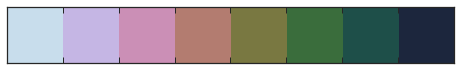

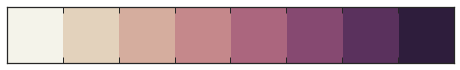

In [44]:
sns.palplot(sns.cubehelix_palette(8, start=0.5, rot=-1.5, hue=0.8, gamma=1.0))
sns.palplot(sns.cubehelix_palette(8, start=0, rot=0.5, light=0.95))

2 215 798.882821011 0.0865583046691
4 108 1018.18741831 0.173116609338
6 72 1066.38140563 0.259674914007
8 54 1084.06042698 0.346233218676
10 43 1089.88437532 0.432791523345
12 36 1096.98253406 0.519349828014
14 31 1102.29125235 0.605908132684
16 27 1101.57264066 0.692466437353
18 24 1102.81876885 0.779024742022
20 22 1054.05862291 0.865583046691
22 20 1023.72390561 0.95214135136
24 18 974.709529921 1.03869965603
26 17 943.343029978 1.1252579607
28 15 879.475435125 1.21181626537
2 842 1108.17514803 0.0497540472386
4 421 1436.53612992 0.0995080944772
6 281 1513.56055965 0.149262141716
8 210 1539.20811224 0.199016188954
10 168 1552.70110889 0.248770236193
12 140 1560.1541182 0.298524283432
14 120 1564.70097014 0.34827833067
16 105 1567.67927991 0.398032377909
18 94 1575.32242874 0.447786425148
20 84 1571.21925762 0.497540472386
22 77 1578.84779348 0.547294519625
24 70 1573.16721829 0.597048566863
26 65 1578.49597986 0.646802614102
28 60 1574.35532454 0.696556661341


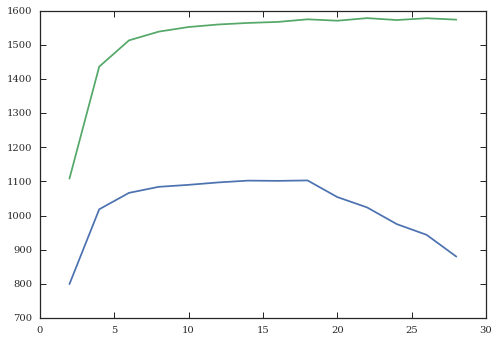

In [60]:
# Optimize SW SNR
obs = obs_list[0]
ng_list = np.arange(2,30,2)
snr_list = []
for ng in ng_list:
    nint = 1
    obs.update_detectors(ngroup=ng, nint=nint, verbose=False)
    nint = np.int(np.round(1800 / obs.multiaccum_times['t_int']))
    obs.update_detectors(ngroup=ng, nint=nint, verbose=False)
    hdu = obs.obs_images(scaled=True, wfe_drift=5, return_oversample=False)
    snr_list.append(hdu['SNR'].data.max())
    print(ng, nint, hdu['SNR'].data.max(), hdu['SAT_LEVEL'].data.max())

obs = obs_list[1]
ng_list2 = np.arange(2,30,2)
snr_list2 = []
for ng in ng_list2:
    nint = 1
    obs.update_detectors(ngroup=ng, nint=nint, verbose=False)
    nint = np.int(np.round(1800 / obs.multiaccum_times['t_int']))
    obs.update_detectors(ngroup=ng, nint=nint, verbose=False)
    hdu = obs.obs_images(scaled=True, wfe_drift=5, return_oversample=False)
    snr_list2.append(hdu['SNR'].data.max())
    print(ng, nint, hdu['SNR'].data.max(), hdu['SAT_LEVEL'].data.max())

    
plt.plot(ng_list, snr_list)
plt.plot(ng_list2, snr_list2)